In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
#import seaborn as sns
import numpy as np
from scipy.optimize import fsolve

# GEO71021 - Modélisation déterministe
## Équation différentielle

Premièrement il faut définir l'équations différentiel qui représente la diffusion de chaleur dans un matériel:

$\frac{\partial T}{\partial t} = D \Bigg[\frac{\partial^{2} T}{\partial x^{2}}\Bigg]$

La varation de température dans le temp ($\frac{\partial T}{\partial t}$) est fonction de la variation de température dans l'espace $\frac{\partial^{2} T}{\partial x^{2}}$ multiplié par un coefficient de diffusivité ($m^2 s^-1$)

On transforme notre équations différentiel en équation de différence (celle est qu'on code):

$T_{i}^{t+1} = T_{i}^{t} + \Delta t D(\frac{T_{i+1}^{t}-2T_{i}^{t} + T_{i-1}^{t}}{\Delta x^{2}})$

L'équation différentiel nous indique un dérivé central d'orde 2 en x et le forward Euler method en t (propagation de cette dérivé vers l'avant dans le temps ($dt$)).

## Exemple de diffusion de chaleur dans une barre de métal

In [2]:
L=0.1 # longueur de la barre
n = 10 # nombre de nodes
T0 = 0 # température initale
T1s = 40# température de surface
#T2s = 20
dx = L/n 
print('dx',dx)

alpha = 0.0001 # diffusivity du matériel du métal dans ce cas-ci
t_final = 60 # temps final de la simul en seconde
dt = 0.1

T = np.ones(n)*T0 # champ de température de départ **** conditions initiale de la barre, extrêment important!!!!!
dTdt = np.empty(n)
t = np.arange(0,t_final, dt) # créer un numpy array de 0 à 60 de step dt

dx 0.01


## Coder la simulation
1. Calcul de la dérivé spatial (profil de température)
2. Propagation de cette dérivée vers l'avant dans la direction temporelle
Deux loops vont nous aider à calculer les champs de température en profondeur et ensuite dans le temps.
La première loop va parcourir notre index temporel de 1 à l'incrément final de la simulation temporelle. Ce loop permet de calculer le profil de température à chaque dt.

Le deuxième loop va parcourir l'index spatial (profondeur) pour calculer la dérivé centrale d'ordre 2 de la température.
   1. Le i devient le noeud central et il va regarder le noeud avant (i-1) et après (i+1) pour calculer la dérivé centrale de température
   2. La deuxième ligne calul la dérivé vers l'avant à partir de la température de surface de la barre, tenu constante à 40°C
   3. La troisième ligne calcul la dérivé vers l'arrière pour la dernier noeud de calcul

In [3]:
%%time
Temp = []
for j in range(0,len(t)):
    for i in range(1,n-1):
        dTdt[i]=alpha*(-(T[i]-T[i-1])/dx**2 + (T[i+1]-T[i])/dx**2) # dérivé centrale
    dTdt[0]=alpha*(-(T[0]-T1s)/dx**2 + (T[1]-T[0])/dx**2) # dérivé forward pour la première donnée avec la temp de surface
    dTdt[n-1]=alpha*(-(T[n-1]-T[n-2])/dx**2) # dérivé backward pour la dernière donnée de la barre
    T = T + dTdt*dt # propagataion vers l'avant de la dérivé temporelle (forward euler method)
    Temp.append(T)

CPU times: user 16.8 ms, sys: 158 µs, total: 16.9 ms
Wall time: 16.8 ms


In [4]:

Temp = np.stack(Temp, axis =0)
print(Temp.shape)
print(Temp)

(600, 10)
[[ 4.          0.          0.         ...  0.          0.
   0.        ]
 [ 7.2         0.4         0.         ...  0.          0.
   0.        ]
 [ 9.8         1.04        0.04       ...  0.          0.
   0.        ]
 ...
 [38.0107714  36.06598699 34.20909656 ... 27.57620325 26.9882744
  26.69099137]
 [38.01521582 36.07477639 34.2220343  ... 27.60395515 27.01733898
  26.72071967]
 [38.01965029 36.08354612 34.23494311 ... 27.63164507 27.04633866
  26.7503816 ]]


(10, 600)


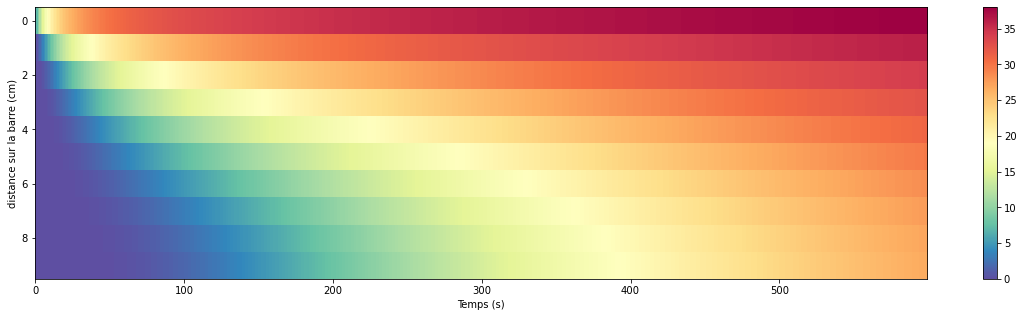

In [5]:
Temp_flip = np.transpose(Temp)
print(Temp_flip.shape)
plt.figure(figsize = (20,5))
plt.imshow(Temp_flip, cmap='Spectral_r', interpolation='nearest', aspect='auto')
plt.xlabel('Temps (s)')
plt.ylabel('distance sur la barre (cm)')
plt.colorbar()
plt.show()

## La barre de métal devient le sol!!
Que doit-on changer pour simuler le régime thermique du sol?

Les coéfficents?

Les intrants?

La géométrie du domaine de modélisation?

In [6]:
filename = '/home/francis/Documents/UQAR/Cours/GEO71021/data_exemple/serpentine_20210308_15min.csv'

bd = pd.read_csv(filename,sep = ',', header = 0)

format = '%Y-%m-%d %H:%M:%S' # spécifie le format dans lequel mon string va être pour créer le datetime

bd['datetime'] = pd.to_datetime(bd['Date'] + ' ' + bd['Time'], format=format) #nouvel colonne datetime
bd = bd.set_index(pd.DatetimeIndex(bd['datetime'])) # je set ma nouvelle datetime comme index

bd.loc[bd['SnowDepth']>250, 'SnowDepth'] = None
bd.loc[bd['SnowDepth']<0, 'SnowDepth'] = 0
bd = bd.fillna(method='ffill')

#bd_test = bd[:'2021-03-01 12:00:09'] # le : signifie jusqu'au début si il est placé devant
#bd_valid = bd['2021-03-01 12:00:09':] # le : signifie jusqu'à la si il est placé derrière
bd

,Date,Time,ValleyRecID,SW-IN,SW-OUT,LW-IN,LW-OUT,PAR-IN,PAR-OUT,AirTemp,...,SnowDepth,PrecipRate,PrecipTotal,BucketWeight,PluvioStatus,WS,WD,WG,BatVolt,datetime
datetime,,,,,,,,,,,,,,,,,,,,,
2020-11-13 13:00:09,2020-11-13,13:00:09,Valley,76.6,9.7,281.4,328.1,190.9,11.6,2.67,...,0.0,0.0,483.97,807.0,0,0.6,65.1,2.1,14.29,2020-11-13 13:00:09
2020-11-13 13:15:09,2020-11-13,13:15:09,Valley,104.7,7.3,283.3,326.4,149.9,9.2,2.65,...,0.0,0.0,483.97,807.0,0,0.1,144.0,1.1,14.30,2020-11-13 13:15:09
2020-11-13 13:30:09,2020-11-13,13:30:09,Valley,53.8,5.7,284.3,325.7,120.6,8.1,2.65,...,0.0,0.0,483.97,807.0,0,0.0,63.9,0.0,14.24,2020-11-13 13:30:09
2020-11-13 13:45:09,2020-11-13,13:45:09,Valley,60.8,5.5,284.1,324.6,117.9,7.2,2.54,...,0.0,0.0,483.97,807.0,0,0.0,270.0,0.0,14.26,2020-11-13 13:45:09
2020-11-13 14:00:09,2020-11-13,14:00:09,Valley,54.1,5.8,281.2,324.2,121.2,7.3,2.38,...,0.1,0.0,483.97,807.0,0,0.8,152.2,2.9,13.68,2020-11-13 14:00:09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-03-08 09:00:09,2021-03-08,09:00:09,Valley,412.6,254.0,236.4,287.5,384.5,592.8,-7.74,...,103.8,0.0,27.45,1387.7,0,3.5,58.5,6.5,14.39,2021-03-08 09:00:09
2021-03-08 09:15:09,2021-03-08,09:15:09,Valley,414.8,355.8,250.0,298.7,718.8,816.7,-7.32,...,103.8,0.0,27.45,1387.7,0,4.3,77.2,7.9,14.28,2021-03-08 09:15:09
2021-03-08 09:30:09,2021-03-08,09:30:09,Valley,522.7,356.0,246.4,301.6,952.3,819.3,-6.74,...,103.8,0.0,27.45,1387.7,0,2.1,344.8,7.2,14.19,2021-03-08 09:30:09


In [7]:
L = 1.5 # longueur de la barre
n = 30 # nombre de nodes
T0 = 273.15 # température initale

dx = L/n 
print('dx :', dx)
alpha = (2e-7)*86400 # diffusivity du matériel d'un sol en m2/s et transformé en jr
print('alpha :',alpha)
dt = 0.01 # en jour car 15 min correspond à 0.01 jr

dx : 0.05
alpha : 0.01728


## Code avec le for loop

In [8]:
%%time
#On active la commande %%time pour nous dire en output le processing time

# on assume ici que notre température de surface qui va "chauffer" notre sol est la température de l'air.
Tsurf = bd['AirTemp'] + 273.15

T = np.ones(n)*T0 # champ de température de départ, profil de température où toutes les températures sont à 0°C
dTdt = np.empty(n) # Même chose ici pour les dérivés mais un array vide
print(T)

Temp = [] #on crée une liste vide pour stocker chaque numpy array qui contient le profil de température calcul
for j in range(0,len(Tsurf)): # loop à travers Tsurf, j devient l'index pour aller chercher la valeur
    for i in range(0,n-1):
        dTdt[i]=alpha*(-(T[i]-T[i-1])/dx**2 + (T[i+1]-T[i])/dx**2) # dérivé centrale
    dTdt[0]=alpha*(-(T[0]-Tsurf[j])/dx**2 + (T[1]-T[0])/dx**2) # dérivé forward pour la première donnée avec la temp de surface associé avec l'index j 
    dTdt[n-1]=alpha*(-(T[n-1]-T[n-2])/dx**2) # dérivé backward pour la dernière donnée de la barre
    T = T + dTdt*dt # propagation vers l'avant de la dérivé temporelle (forward euler method)
    Temp.append(T) # on stock le profil de température T
    
Temp = np.stack(Temp, axis =0)


[273.15 273.15 273.15 273.15 273.15 273.15 273.15 273.15 273.15 273.15
 273.15 273.15 273.15 273.15 273.15 273.15 273.15 273.15 273.15 273.15
 273.15 273.15 273.15 273.15 273.15 273.15 273.15 273.15 273.15 273.15]
CPU times: user 874 ms, sys: 0 ns, total: 874 ms
Wall time: 896 ms


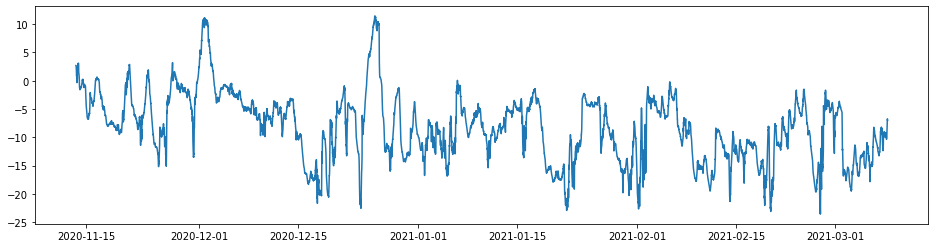

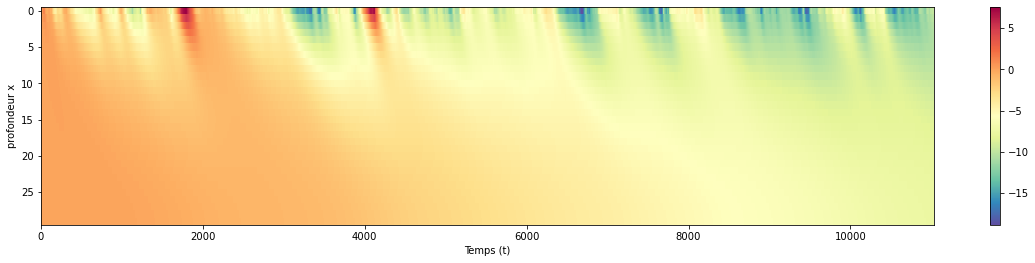

In [9]:
Temp_flip = np.transpose(Temp)
plt.figure(figsize = (16,4))
plt.plot(bd['AirTemp'])
plt.show()

plt.figure(figsize = (20,4))
plt.imshow(Temp_flip -273.15, cmap='Spectral_r', interpolation='nearest', aspect='auto')
plt.xlabel('Temps (t)')
plt.ylabel('profondeur x')
plt.colorbar()
plt.show()

## Code avec Numpy

Les for loop sont faciles à coder et à comprendre. Malheureusement ils ne sont pas très efficaces en termes de puissance de calcul.
La librairie numpy est codé en C++ et est bcp plus rapide. Essayons de coder en numpy en utilisant la vectorisation.

1. On va utiliser le for loop pour parcourir l'array Tsurf et les numpy array pour calculer le profil de température à chaque iteration.

2. On calcul les dérivés CENTRALES du profil de température dTdt SAUF le première et la dernière (ex. dTdt[1:-1]).

3. On calcul la dérivée centrale de la première donnée avec la température de surface.

4. On calcul la dérivée arrière de la dernière donnée du profil de température.

In [10]:
%%time

T = np.ones(n)*T0 # champ de température de départ
dTdt = np.empty(n)
print(T)

Temp = []
Tsurf = np.array(bd['AirTemp']) + 273.15
for i in Tsurf:
    dTdt[1:-1]=alpha*(-(T[1:-1]-T[:-2])/dx**2 + (T[2:]-T[1:-1])/dx**2) # dérivé centrale
    dTdt[0]=alpha*(-(T[0]-i)/dx**2 + (T[1]-T[0])/dx**2) # dérivé centrale pour la première donnée avec la temp de surface
    dTdt[-1]=alpha*(-(T[-1]-T[-2])/dx**2) # dérivé backward pour la dernière donnée de la barre
    T = T + dTdt*dt # propagation vers l'avant de la dérivé temporelle (forward euler method)
    Temp.append(T)

[273.15 273.15 273.15 273.15 273.15 273.15 273.15 273.15 273.15 273.15
 273.15 273.15 273.15 273.15 273.15 273.15 273.15 273.15 273.15 273.15
 273.15 273.15 273.15 273.15 273.15 273.15 273.15 273.15 273.15 273.15]
CPU times: user 233 ms, sys: 27 ms, total: 260 ms
Wall time: 231 ms


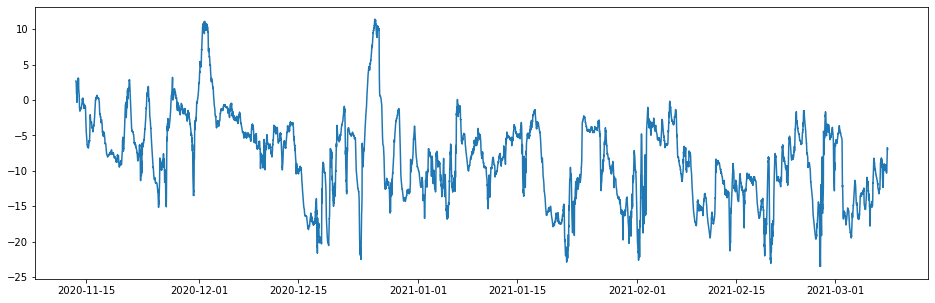

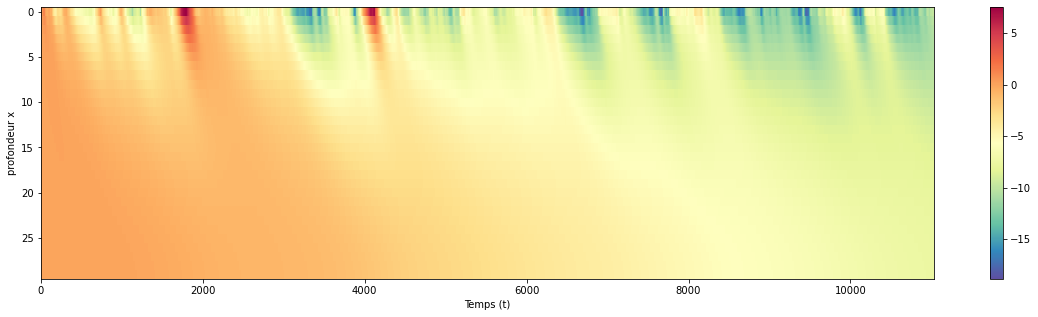

In [11]:
Temp_flip = np.transpose(Temp)
plt.figure(figsize = (16,5))
plt.plot(bd['AirTemp'])
plt.show()

plt.figure(figsize = (20,5))
plt.imshow(Temp_flip -273.15, cmap='Spectral_r', interpolation='nearest', aspect='auto')
plt.xlabel('Temps (t)')
plt.ylabel('profondeur x')
plt.colorbar()
plt.show()

## Bilan d'énergie de surface

Il faut trouver notre température de surface avec un bilan d'énergie de surface pour améliorer notre précision car assumer que la température de surface est la même que la température est une grosse assomption qui se peut dans quelques contextes spécifiques.

Ce bilan d'énergie de surface est représente la quantité d'énergie qui arrive de l'atmosphère comparé à l'énergie perdu par la surface avec la méthode pour des surfaces routières (asphalte)**, proposée par Solaimanian et Kennedy (1993).

$q_{net} = q_s + q_a \pm q_c \pm q_k - q_r$

$q_s = $ energy absorbed from direct solar radiation. Radiation solaire qu'on mesure moins réfléchis qu'on mesure aussi:

$$
q_s = albedo * R_{solar}
$$
$$
ou
$$
$$
q_s = R_{incident} - R_{reflected}
$$

$q_a = $ energy absorbed from terrestial radiation. Infra-rouge (chaleur) reçu de l' atmosphère. On ne mesure pas cette variable mais nous l'allons l'approximer avec la température ambiante:

$$
q_a = \epsilon_a \sigma T_{air}^4
$$
where : 
$\epsilon$ correspond l'émissivité de la surface (neige,soil...), $\sigma$ = Stefan Boltzman constant = $5.68e^{-8}$ W m$^{-2}$ °K$^{-4}$, $T_{air}$ =  the air temperature (°K),$\rho$ = the vapor pressure

$q_c = $ energy transferred to the body (sol dans notre cas) from convection (chaleur de l'air ambiant et du vent). Nous allons l'approximer avec la température de l'air et la vitesse du vent.

$q_k = $ energy transferred to the body (sol dans notre cas) from  conduction (chaleur transmis au sol)*** ce que l'on va modéliser

$q_r = $ energy emitted from the body trough outgoing radiation. Longue longueur d'onde (infra-rouge émis par la surface


On peut donc résoudre notre équation à chaque pas de temps en fonction des différentes pour trouver notre température de surface à chaque pas de temps, celle-ci est notre seule inconnue.

$q_{net} = q_s + q_a \pm q_c \pm q_k - q_r$

## Ajout de la température de surface en fonction du bilan d'énergie

Chaque flux contribue au bilan d'énergie net. on met le bilan à zéro ($q_{net}$} et on résout l'équation pour trouver la température de surface qui est notre seul inconnue.

In [12]:
def surf_bilan(Tsurf,swin,swout,Tair,Vvent,Td,L):
    emiss = 0.98
    stefboltz = 5.68e-8
    k = 0.5 # la conductivité thermique de votre milieu (sol ou neige)
    hc = 10.45 - Vvent + 10*Vvent**0.5

    qs = swin-swout
    qa = emiss*stefboltz*Tair**4
    qc = hc*(Tsurf-Tair)
    qk = k/L*(Tsurf-Td)
    qr = emiss*stefboltz*Tsurf**4
    return qs + qa - qc - qk - qr 

In [13]:
%%time

T = np.ones(n)*273.15 # champ de température de départ
dTdt = np.empty(n)

Temp = []
Temp_surface = []
Tsurf_init = np.array(bd['AirTemp'])+273.15
for i in range(0,len(Tsurf_init)):
    Tair = bd['AirTemp'][i]+273.15
    swin= bd['SW-IN'][i]
    swout = bd['SW-OUT'][i]
    Vvent = bd['WS'][i]
    if i == 0:
        Td = 273.15
    else:
        Td = T[-1] # je prends ma dernière température du loop dernier pour mon qk de mon bilan d'énergie
    # j'utilise la fonction fsolve de scipy pour résoudre l'équation de bilan d'énergie et trouver ma Tsurf    
    Tsurf = fsolve(surf_bilan,[0],(swin,swout,Tair,Vvent,Td,L))
    
    dTdt[1:-1]=alpha*(-(T[1:-1]-T[:-2])/dx**2 + (T[2:]-T[1:-1])/dx**2) # dérivé centrale
    dTdt[0]=alpha*(-(T[0]-Tsurf)/dx**2 + (T[1]-T[0])/dx**2) # dérivé centrale pour la première donnée avec la temp de surface
    dTdt[-1]=alpha*(-(T[-1]-T[-2])/dx**2) # dérivé backward pour la dernière donnée de la barre
    T = T + dTdt*dt # propagation vers l'avant de la dérivé temporelle (forward euler method)
    Temp.append(T)
    Temp_surface.append(Tsurf)
                        
Temp_flip = np.transpose(Temp)
#bd = pd.concat([bd,pd.Series(Tsurf)],axis =1,ignore_index=True)

bd['Tsurf'] = pd.Series(Temp_surface, index = bd['datetime'])

CPU times: user 3.79 s, sys: 7.59 ms, total: 3.8 s
Wall time: 3.77 s


<ipython-input-14-fc851fbb2e22>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(x_tick)
<ipython-input-14-fc851fbb2e22>:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(x_tick)
<ipython-input-14-fc851fbb2e22>:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax3.set_xticklabels(x_tick)
<ipython-input-14-fc851fbb2e22>:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax4.set_xticklabels(x_tick)


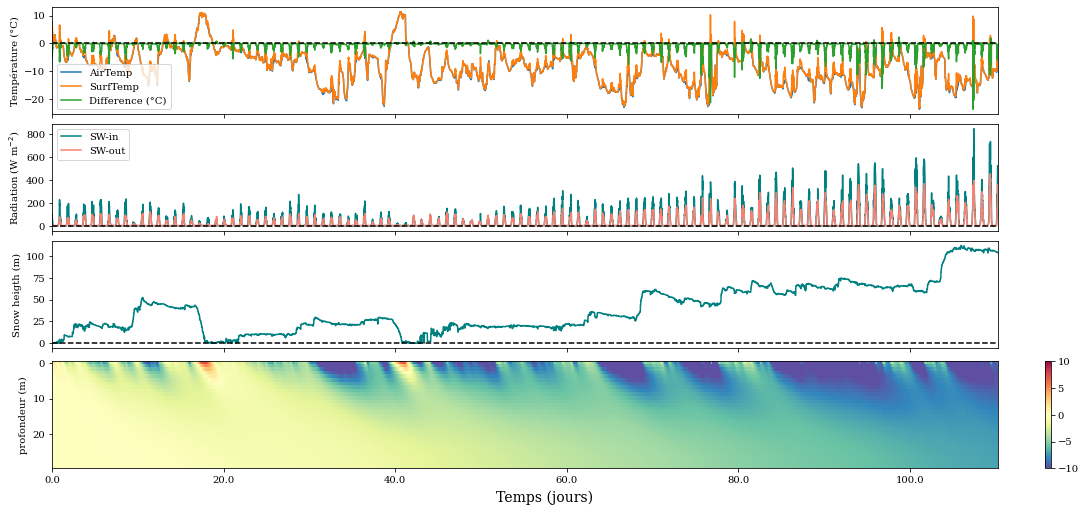

In [14]:
plt.rcParams["font.family"] = "serif"
fig, (ax1,ax2,ax3,ax4) = plt.subplots(ncols = 1, nrows = 4, figsize = (15,7), sharey = False, sharex = True, constrained_layout = True)
fig.supxlabel( "Temps (jours)", fontsize = 14)

ax1.plot(np.array(bd['AirTemp']), label = 'AirTemp')
ax1.plot(np.array(bd['Tsurf'])-273.15, label = 'SurfTemp')
ax1.plot(np.array(bd['AirTemp'])-np.array(bd['Tsurf']-273.15), label = 'Difference (°C)')
ax1.axhline(y=0,linestyle='dashed',color = 'black')
x_tick = ax1.get_xticks()*dt
ax1.set_xticklabels(x_tick)
ax1.set_ylabel('Température (°C)')
ax1.legend()

ax2.plot(np.array(bd['SW-IN']), label = r'SW-in', color = 'teal')
ax2.plot(np.array(bd['SW-OUT']), label = 'SW-out', color = 'salmon')
ax2.axhline(y=0,linestyle='dashed',color = 'black')
ax2.set_ylabel('Radiation (W m$^{-2}$)')
ax2.legend()
ax2.set_xticklabels(x_tick)

ax3.plot(np.array(bd['SnowDepth']), label = r'SnowDepth', color = 'teal')
ax3.axhline(y=0,linestyle='dashed',color = 'black')
ax3.set_ylabel('Snow heigth (m)')
#ax3.legend()
ax3.set_xticklabels(x_tick)

p2 = ax4.imshow(Temp_flip-273.15, cmap='Spectral_r', interpolation='nearest', aspect='auto', vmin = -10, vmax =10)
ax4.set_ylabel('profondeur (m)')
ax4.set_xticklabels(x_tick)
#y_tick = ax4.get_yticks()*dx
#ax4.set_yticklabels(y_tick)
#ax4.set_yticklabels([0,0,0.25,0.5,0.75,1,1.25,1.5])
plt.colorbar(p2,ax=ax4)

Est-ce qu'il manque quelque chose? 

Est-ce que les température vous semble réaliste?

Avons-nous oublier un flux de chaleur à quelque part?

## Ajout d'une couche de neige dans le modèle

In [15]:

L = 2.5 # Hauteur/profondeur de modélisation

n = 50 # nombre de nodes
print(n)
T0 = 273.15 # température initale
dx = L/n 
Hsoil = int(L/dx-1/dx)
print('dx :', dx)
print('Hsoil :',Hsoil)
alpha_soil = (5 * 10**-7)*86400 # diffusivity du matériel d'un sol en m2/s et transformé en jr
alpha_snow = (2 * 10**-7)*86400 # diffusivity du matériel d'un sol en m2/s et transformé en jr
print(alpha_soil-alpha_snow)
print('alpha :',alpha)
dt = 0.01 # en jour car 15 min correspond à 0.01 jr

#Td = T[0][-1]
print(T[-1])
Td=273.15

50
dx : 0.05
Hsoil : 30
0.025919999999999995
alpha : 0.01728
266.11386077647364


In [16]:
%%time

T = np.ones(n)*273.15 # champ de température de départ
dTdt = np.empty(n)
Temp = np.zeros((len(Tsurf_init), n))
Temp_surface = []
Tsurf_init = np.array(bd['AirTemp'])+273.15
for j in range(0,len(Tsurf_init)):
    
    Tair = bd['AirTemp'][j]+273.15
    swin= bd['SW-IN'][j]
    swout = bd['SW-OUT'][j]
    Vvent = bd['WS'][j]
    Hs = Hsoil -int((bd['SnowDepth'][j]/100)/dx)

    #premier stime step je prends 0°C au fond pour mon qk mais après je prends ma dernière valeur.
    if j == 0:
        Td = 273.15
    else:
        Td = T[-1]
        
    Tsurf = fsolve(surf_bilan,[0],(swin,swout,Tair,Vvent,Td,Hs*dx))

    # Je commence mon loop dans mon profil d'air, neige et sol
    # je base une condition sur mon i itérateur de profondeur, pour savoir où je suis dans ma profondeur (air,neige,sol)
    for i in range(0,n-1):
        if i < Hs: # Est-ce que je suis dans l'air?
            T[i] = Tair
            #dTdt[i] = 0
        elif ((i >= Hs) and (i < Hsoil)): # J'applique léquation avec la diffusivité de la neige
            dTdt[i]=alpha_snow*(-(T[i]-T[i-1])/dx**2 + (T[i+1]-T[i])/dx**2) # dérivé centrale
            T[i] = T[i] + dTdt[i]*dt
        else: # J'applique léquation avec la diffusivité du sol
            dTdt[i]=alpha_soil*(-(T[i]-T[i-1])/dx**2 + (T[i+1]-T[i])/dx**2) # dérivé centrale
            T[i] = T[i] + dTdt[i]*dt # propagation vers l'avant de la dérivé temporelle (forward euler method)
        dTdt[Hs]=alpha_snow*(-(T[Hs]-Tsurf)/dx**2 + (T[Hs+1]-T[Hs])/dx**2) # dérivé centrale pour la première donnée avec la temp de surface associé avec l'index j 
        dTdt[n-1]=alpha_soil*(-(T[-1]-T[n-2])/dx**2) # dérivé backward pour la dernière donnée de la barre
        T[Hs] = T[Hs] + dTdt[Hs]*dt
        T[-1] = 273.15#T[-1] + dTdt[-1]*dt
    Temp_surface.append(Tsurf)
    Temp[j] = T # on stock le profil de température 

    #print(T)
#Temp = np.stack(Temp, axis =0)                  
Temp_flip = np.transpose(Temp)

bd['Tsurf'] = pd.Series(Temp_surface, index = bd['datetime'])

CPU times: user 10.6 s, sys: 21.1 ms, total: 10.6 s
Wall time: 10.7 s


In [17]:
# On enlève les températures dans l'air pour la visualisation
print(Temp.shape)
for j in range(0,len(Tsurf_init)):
    Hs = Hsoil -int((bd['SnowDepth'][j]/100)/dx)
    for i in range(0,n-1):
        if i < Hs:
            Temp[j][i] = np.nan # je met un Nan (not a number) pour la visualisation
        else:
            Temp[j][i] = Temp[j][i]
            
Temp_flip = np.transpose(Temp)

(11029, 50)


[30.   30.   30.   ...  9.24  9.24  9.22]


<ipython-input-18-58def253c049>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(x_tick)
<ipython-input-18-58def253c049>:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(x_tick)
<ipython-input-18-58def253c049>:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels([1.75,1.5,1,0.5,0,-0.5,-1])


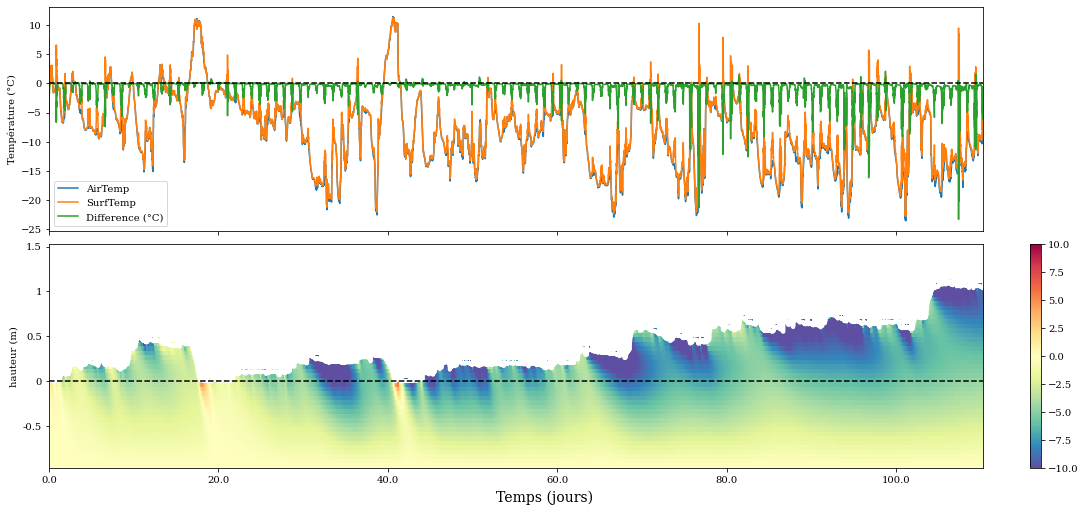

In [18]:
plt.rcParams["font.family"] = "serif"
fig, (ax1,ax2) = plt.subplots(ncols = 1, nrows = 2, figsize = (15,7), sharey = False, sharex = True, constrained_layout = True)
fig.supxlabel( "Temps (jours)", fontsize = 14)

ax1.plot(np.array(bd['AirTemp']), label = 'AirTemp')
ax1.plot(np.array(bd['Tsurf'])-273.15, label = 'SurfTemp')
ax1.plot(np.array(bd['AirTemp'])-np.array(bd['Tsurf']-273.15), label = 'Difference (°C)')
ax1.axhline(y=0,linestyle='dashed',color = 'black')
x_tick = ax1.get_xticks()*dt
ax1.set_xticklabels(x_tick)
ax1.set_ylabel('Température (°C)')
ax1.legend()

hs = np.array(Hsoil-(bd['SnowDepth']/100)/dx)
print(hs)
p2 = ax2.imshow(Temp_flip-273.15, cmap='Spectral_r', interpolation='nearest', aspect='auto', vmin = -10, vmax =10)
ax2.plot(hs, label = r'SnowDepth', color = 'white', linewidth=4)
ax2.set_ylabel('hauteur (m)')
ax2.set_xticklabels(x_tick)
ax2.set_yticklabels([1.75,1.5,1,0.5,0,-0.5,-1])
ax2.axhline(y=Hsoil,linestyle='dashed',color = 'black')
plt.colorbar(p2,ax=ax2)

Satisfait de votre régime thermique?

Avez-vous oublier un flux de chaleur à quelque part?

Vos données collent bien avec celles mesurées?

## Comment valider votre modèle??
Les résultats du modèle est encapsuler dans un numpy array 2D.

Comment comparer chaque valeur de la modélisation avec la mesure de la sonde thermique à la surface du sol et à 30 cm du sol.

Vous devez aller chercher la série temporelle dans votre modélisation qui correspond à la bonne profondeur.

Comparer votre série temporelle mesurée avec celle modélisée. Vous pouvez grapher la différence entre les deux série dans le temps et faire une RMSE entre vos deux séries temporelles et me sortir un graphique non temporelle qui compare vos deux série.

** Attention, vos données seront corrélées entre eux (15 min) donc rééchantillonner vous données aux 6h avant de les comparer pour éviter une sous estimation de votre RMSE.

Je ne procure pas de code pour cette section car vous avez déjà fait le même genre d'opérations.

CROYEZ EN VOS SKILLS DE CODE!!

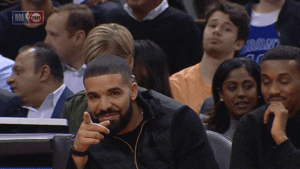
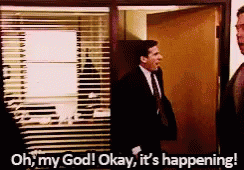